# Observations from analysing tweets by Trump, Obama and Biden

In [1]:
import tweepy
import pandas as pd
import json
import time
import datetime as dt
import csv
import GetOldTweets3 as got;
import glob
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.gridspec as gridspec
import re

In [2]:
user_names_df_clean = pd.read_csv('biden_trump_obama_clean_2008_2020')

## Brief Overview:

 - The goal of this presentation is highlight key observations after having scraped the Twitter feeds of Donald Trump, Barack Obama and Joe Biden via the GetOldTweet3 library. I utilised the wordcloud library inorder to visualise the most common words utilised by the figures inquestion across their most popular tweets.

 - The dataset consists of 56,340 tweets dating back form the 1st of Jan 2008 up until 14th September 2020.

### How frequently did Trump, Obama and Biden tweet over the years?

 - Obama was quite an active tweeter during his second presidential term (2013 - 2016), particularly during the early years (2013 - 2014). However since leaving office, he has become quite a passive tweeter.
 - Trump on the hand has been a highly active tweeter with his frequency of usage exploding from 2013 onwards.
 - We can see that Biden only started tweeting from 2012 onwards. Whilst we can see that he was quite an active tweeter during 2012, he very rarely tweeted from 2013 through to 2018 where he spent the majority of this period serving as the Vice President. Though his frequency of usage has certainly increased from 2019 onwards, in the lead up to the 2020 Presidential elections.

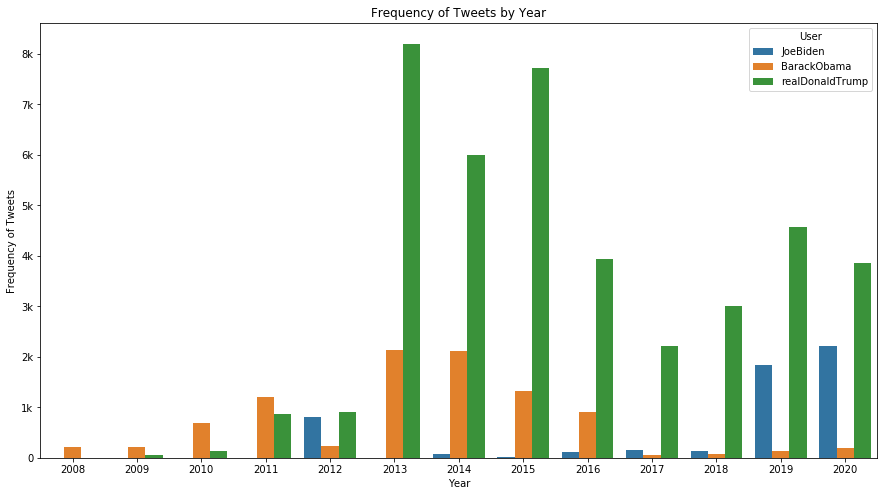

In [3]:
plt.figure(figsize = (15, 8));
palette ={"JoeBiden": "C0", "BarackObama": "C1", "realDonaldTrump": "C2"}
sb.countplot(data = user_names_df_clean, x = 'Year', hue = 'User', palette = palette, hue_order = ["JoeBiden", "BarackObama", "realDonaldTrump"]);
plt.ylabel('Frequency of Tweets');
plt.title('Frequency of Tweets by Year');
plt.yticks(np.arange(0, 8001, 1000), [0,'1k','2k','3k','4k','5k','6k','7k','8k']);

### Average number of retweets generated per tweet between Trump, Obama and Biden over the years?

It's really interesting to see how Obama's average retweet per tweet numbers really exploded from 2016 onwards despite having become a far more passive tweeter just as his second presidential term ended. Quality over quantity.

In [4]:
#We'll need to do some cleaning in order to answer the supporting questions:

#Groupy to obtain sum of retweets by year
tweet_retweet = user_names_df_clean.groupby(['User', 'Year']).Retweets.sum().reset_index()

#Groupby to obtain the frequency of tweets by year
tweet_frequency = user_names_df_clean[['User', 'Year', 'Tweet_id']].groupby(['User', 'Year']).Tweet_id.count().reset_index()
tweet_frequency.rename(columns = {'Tweet_id': 'Tweet_frequency'}, inplace = True)

#Merge the two DataFrames so we get retweets and frequency of tweets by year
tweet_frequency_retweet = pd.merge(tweet_retweet, tweet_frequency)

#Create additional column which calculates the average retweet per tweet ratio
tweet_frequency_retweet['Retweet_per_Tweet_ratio'] = tweet_frequency_retweet.Retweets / tweet_frequency_retweet.Tweet_frequency

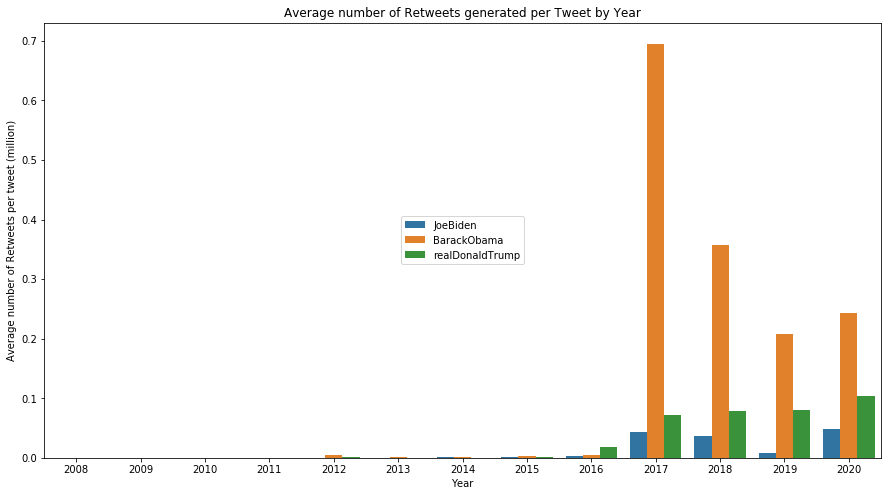

In [5]:
#Plot Retweet per Tweet ratio by year
plt.figure(figsize = (15, 8));
sb.barplot(data = tweet_frequency_retweet, x = 'Year', y = 'Retweet_per_Tweet_ratio', hue = 'User', palette = palette, hue_order = ["JoeBiden", "BarackObama", "realDonaldTrump"]);
plt.ylabel('Average number of Retweets per tweet (million)');
label_range_2 = np.arange(0, 8, 1);
plt.yticks(label_range_2 * 100000, label_range_2 / 10);
plt.title('Average number of Retweets generated per Tweet by Year');
plt.legend(loc='center');

### WordCloud to analyse sentiment of the top 250 most retweeted tweets from each user (2017 onwards only)

It isn't at all surprising and a tad bit worrying to see Trumps most retweeted tweets taking a nationalistic tone with words such as 'Make', 'America', 'Great' and 'China' frequently appearing. It is really interesting to see how Biden's most retweeted tweets are those where he is frequently going on the attack against Donald Trump in the build up to the 2020 Presidential elections. This election is certianly proving to be one of the most polarising of modern times.

In [37]:
#Setting a global variable for the range of year cuts in our dataset
year_range = np.arange(2008, 2021, 1)

#Create individual DataFrames for Obama, Trump and Biden
obama_df = user_names_df_clean[user_names_df_clean.User == 'BarackObama']
trump_df = user_names_df_clean[user_names_df_clean.User == 'realDonaldTrump']
biden_df = user_names_df_clean[user_names_df_clean.User == 'JoeBiden']

#Sort dataframes in order of most retweeted and drop tweets without text
obama_retweet_df = obama_df.sort_values(by = ['Retweets'], ascending = False).dropna(subset = ['Text'])
trump_retweet_df = trump_df.sort_values(by = ['Retweets'], ascending = False).dropna(subset = ['Text'])
biden_retweet_df = biden_df.sort_values(by = ['Retweets'], ascending = False).dropna(subset = ['Text'])

#function will enable us to select the number of top retweets to appear in first parameter as well as the range of
#years to look at for either Trump, Obama or Biden
def wordcloud_retweet(top_number, trump_year = year_range, obama_year = year_range, biden_year = year_range):
    
    #Loop through the individual DataFrames and collect the tweets into a list of tweets
    obama_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in obama_retweet_df[obama_retweet_df.Year.isin(obama_year)].dropna(subset = ['Text']).Text.head(top_number)]
    trump_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in trump_retweet_df[trump_retweet_df.Year.isin(trump_year)].dropna(subset = ['Text']).Text.head(top_number)]
    biden_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in biden_retweet_df[biden_retweet_df.Year.isin(biden_year)].dropna(subset = ['Text']).Text.head(top_number)]    

    #Create empty lists to house the individual words from the individual tweets
    obama_series = []
    trump_series = []
    biden_series = []
    
    #loop through obama_ls, trump_ls and populate empty list with words
    for tweet in obama_ls:
        splits = tweet.split()
        for word in splits:
            obama_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))

    for tweet in trump_ls:
        splits = tweet.split()
        for word in splits:
            trump_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))

    for tweet in biden_ls:
        splits = tweet.split()
        for word in splits:
            biden_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))
    
    #Let's combine all the tweets into one big text and build a word cloud off the back of this
    obama_text = " ".join(word for word in obama_series)
    trump_text = " ".join(word for word in trump_series)
    biden_text = " ".join(word for word in biden_series)
    
    #Let's combine all the tweets into one big text and build a word cloud off the back of this
    obama_text = " ".join(tweet for tweet in obama_series)
    trump_text = " ".join(tweet for tweet in trump_series)
    biden_text = " ".join(tweet for tweet in biden_series)

    #Generate masks for Obama and Trump
    mask_obama = np.array(Image.open('obama_1.png'))
    mask_trump = np.array(Image.open('trump_3.png'))
    mask_biden = np.array(Image.open('biden_edit.png'))

    #Create a stopword list
    stopwords = set(STOPWORDS)
    stopwords.update(["will", 'of', 'a', 'well', 'way', 've', 'don', 'let', 'thing', 'day', 'thing' 'keep', 'two', 'see', 're', 'today', 'week', 'far', 'now', 'act'])

    #Generate a word cloud image
    wordcloud_obama = WordCloud(background_color="white", stopwords = stopwords, max_words = 50, mask=mask_obama, contour_width=3, contour_color='steelblue', collocations=False).generate(obama_text)
    wordcloud_trump = WordCloud(background_color="white", stopwords = stopwords, max_words = 50, mask=mask_trump, contour_width=3, contour_color='steelblue', collocations=False).generate(trump_text)
    wordcloud_biden = WordCloud(background_color="white", stopwords = stopwords, max_words = 50, mask=mask_biden, contour_width=3, contour_color='steelblue', collocations=False).generate(biden_text)

    #Display the generated image:
    plt.figure(figsize = (32, 16))

    plt.subplot(1, 3, 1)
    plt.imshow(wordcloud_trump, interpolation = 'bilinear')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(wordcloud_obama, interpolation = 'bilinear')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(wordcloud_biden, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

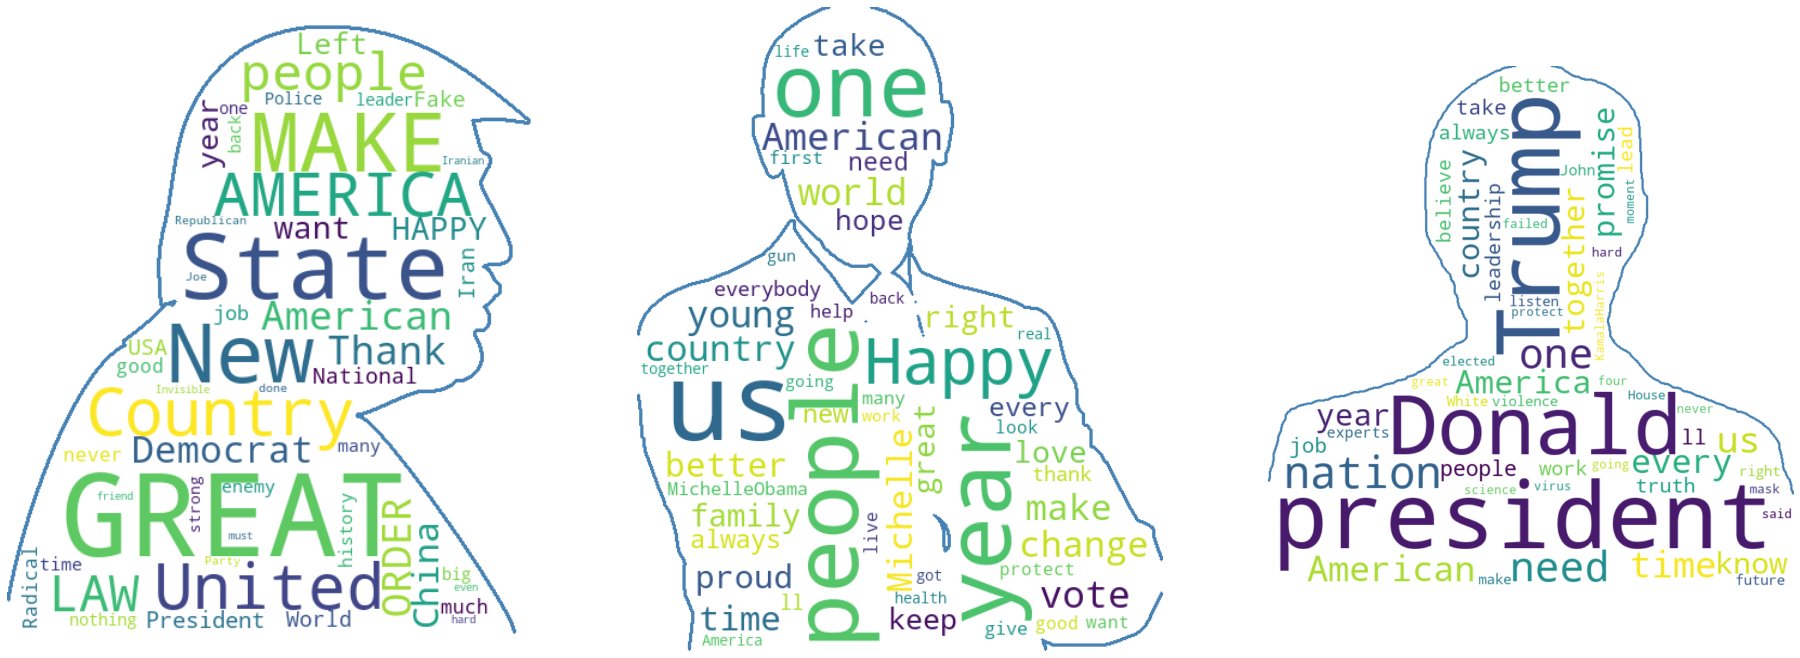

In [38]:
wordcloud_retweet(250, np.arange(2017, 2021, 1), np.arange(2017, 2021, 1), np.arange(2017, 2021, 1))

Once you're ready to finish your presentation, check your output by using nbconvert to export the notebook and set up a server for the slides. From the terminal or command line, use the following expression:

**jupyter nbconvert Explanatory_analysis_twitter_obama _trump_biden.ipynb --to slides --post serve --template output_toggle**

This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation!